# Auto-Rotating Perceptrons (ARP)

Example of use of the `AutoRotDense` Keras layer. A comparison against a neural network with classic perceptrons is showed. We can observe a performance improvement when using ARP at deep neural models with saturated activation functions (like sigmoid).

This notebook was executed in Google Colaboratory.

You can run it in colab here: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielSaromo/ARP/blob/master/examples/example_CIFAR10_Keras.ipynb)

Code based on the official Keras example: https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

Reference: **ARP paper**: https://arxiv.org/pdf/1910.02483.pdf

Notebook made by [Daniel Saromo Mori](http://danielsaromo.github.io/).

# Install ARP library for Keras

In [1]:
!pip install arpkeras

The library name for the `pip` installation is in lowercase.

In [2]:
from ARPkeras import AutoRotDense

Check the uppercases of the library name while importing.

# Inference of the CIFAR10 dataset

In [3]:
import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from skimage.color import rgb2gray
import numpy as np

batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = np.array([rgb2gray(img) for img in x_train])
x_test = np.array([rgb2gray(img) for img in x_test])

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#x_train /= 255
#x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 2s 0us/step
50000 train samples
10000 test samples


Let's check the limits of the input data, to then define `xmin_lim` and `xmax_lim`:

In [4]:
x_train.min(), x_train.max()

(0.0, 1.0)

In [5]:
x_test.min(), x_test.max()

(0.0, 1.0)

## Model with classic perceptrons

In [6]:
#Model with classic perceptrons

model_classic = Sequential()
model_classic.add(Dense(50, activation='sigmoid', input_shape=(1024,)))
model_classic.add(Dense(50, activation='sigmoid'))
model_classic.add(Dense(40, activation='sigmoid'))
model_classic.add(Dense(40, activation='sigmoid'))
model_classic.add(Dense(30, activation='sigmoid'))
model_classic.add(Dense(num_classes, activation='softmax'))

model_classic.summary()

model_classic.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_classic = model_classic.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_classic = model_classic.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_classic[0])
print('Test accuracy:', score_classic[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                51250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
Total params: 59,020
Trainable params: 59,020
Non-trainable params: 0
____________________________________________________

## Model with ARP

The ARP model has the same architecture as the classical model, but with ARP dense layers (`AutoRotDense`) instead of classical dense layers (`Dense`).

In [7]:
#Model with ARP

print("Range of the train and test data: From 0 to 1")
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

print("Range of the activation function output: `sigmoid`: From 0 to 1")

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

xmin_lim=0
xmax_lim=1

print("Hence, we get that: `xmin_lim` =", xmin_lim,"and `xmax_lim` =", xmax_lim)

print("ARP can be executed by defining just one hyperparameter: `L`")
L = 4 #since the sigmoid activation function $\sigma(z)$ is not saturated in the range abs(z) <= L = 4 

model_ARP = Sequential()
model_ARP.add(AutoRotDense(50, input_shape=(1024,), xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, activation='sigmoid'))
model_ARP.add(AutoRotDense(50, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, activation='sigmoid'))
model_ARP.add(AutoRotDense(40, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, activation='sigmoid'))
model_ARP.add(AutoRotDense(40, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, activation='sigmoid'))
#By default the `AutoRot` flag of the Auto-Rotating layers is True.
model_ARP.add(AutoRotDense(30, activation='sigmoid', xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=True))
model_ARP.add(Dense(num_classes, activation='softmax'))# the last layer does not need to be ARP

model_ARP.summary()

model_ARP.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_ARP = model_ARP.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_ARP = model_ARP.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_ARP[0])
print('Test accuracy:', score_ARP[1])

Range of the train and test data: From 0 to 1
0.0 1.0 0.0 1.0
Range of the activation function output: `sigmoid`: From 0 to 1
0.0 1.0 0.0 1.0
Hence, we get that: `xmin_lim` = 0 and `xmax_lim` = 1
ARP can be executed by defining just one hyperparameter: `L`
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
auto_rot_dense (AutoRotDense (None, 50)                51250     
_________________________________________________________________
auto_rot_dense_1 (AutoRotDen (None, 50)                2550      
_________________________________________________________________
auto_rot_dense_2 (AutoRotDen (None, 40)                2040      
_________________________________________________________________
auto_rot_dense_3 (AutoRotDen (None, 40)                1640      
_________________________________________________________________
auto_rot_dense_4 (AutoRotDen (None, 30)                1230  

ARP model has lower test loss and a higher test accuracy!

## Model with ARP layers with the `AutoRot` flag turned off

You can use the `AutoRotDense` layers with the `AutoRot` argument set to `False` in order to deactivate the Auto-Rotation.

In [8]:
#Model with flagARPoff

print("Range of the train and test data: From xmin_lim=0 to xmax_lim=1")
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

xmin_lim=0
xmax_lim=1

print("ARP can be executed by defining just one hyperparameter: `L`")
L = 4 #since the sigmoid activation function $\sigma(z)$ is not saturated in the range abs(z) <= L = 4 

model_flagARPoff = Sequential()
model_flagARPoff.add(AutoRotDense(50, input_shape=(1024,), xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=False, activation='sigmoid'))
model_flagARPoff.add(AutoRotDense(50, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=False, activation='sigmoid'))
model_flagARPoff.add(AutoRotDense(40, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=False, activation='sigmoid'))
model_flagARPoff.add(AutoRotDense(40, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=False, activation='sigmoid'))
model_flagARPoff.add(AutoRotDense(30, xmin_lim=xmin_lim, xmax_lim=xmax_lim, L=L, AutoRot=False, activation='sigmoid'))
model_flagARPoff.add(Dense(num_classes, activation='softmax'))# the last layer does not need to be flagARPoff

model_flagARPoff.summary()

model_flagARPoff.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_flagARPoff = model_flagARPoff.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score_flagARPoff = model_flagARPoff.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_flagARPoff[0])
print('Test accuracy:', score_flagARPoff[1])

Range of the train and test data: From xmin_lim=0 to xmax_lim=1
0.0 1.0 0.0 1.0
ARP can be executed by defining just one hyperparameter: `L`
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
auto_rot_dense_5 (AutoRotDen (None, 50)                51250     
_________________________________________________________________
auto_rot_dense_6 (AutoRotDen (None, 50)                2550      
_________________________________________________________________
auto_rot_dense_7 (AutoRotDen (None, 40)                2040      
_________________________________________________________________
auto_rot_dense_8 (AutoRotDen (None, 40)                1640      
_________________________________________________________________
auto_rot_dense_9 (AutoRotDen (None, 30)                1230      
_________________________________________________________________
dense_7 (Dense)              (None, 10)      

This model has to generate similar results than the classic model.

# Performance comparison graphs

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

## Loss curves

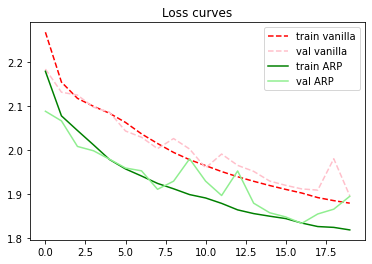

In [10]:
plt.plot(history_classic.history['loss'], '--', color='red', label='train vanilla')
plt.plot(history_classic.history['val_loss'], '--', color='pink', label='val vanilla')
plt.plot(history_ARP.history['loss'], color='green', label='train ARP')
plt.plot(history_ARP.history['val_loss'], color='lightgreen', label='val ARP')
plt.title('Loss curves')
plt.legend()
plt.show()

We can see that with the Auto-Rotation, the initial loss of the network is lower, and it decreases faster to a lower value.

## Accuracy curves

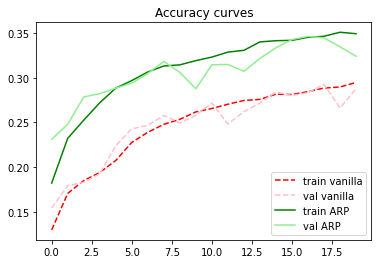

In [11]:
plt.plot(history_classic.history['accuracy'], '--', color='red', label='train vanilla')
plt.plot(history_classic.history['val_accuracy'], '--', color='pink', label='val vanilla')
plt.plot(history_ARP.history['accuracy'], color='green', label='train ARP')
plt.plot(history_ARP.history['val_accuracy'], color='lightgreen', label='val ARP')
plt.title('Accuracy curves')
plt.legend()
plt.show()

The final accuracy of the ARP model is bigger than with classic (vanilla) perceptrons.

## Comparing the vanilla perceptrons and the AutoRot perceptrons with the ARP flag turned off

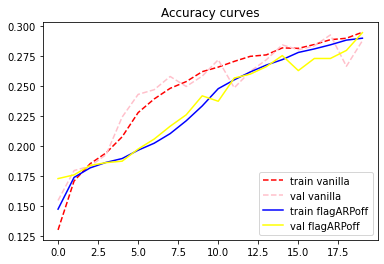

In [13]:
plt.plot(history_classic.history['accuracy'], '--', color='red', label='train vanilla')
plt.plot(history_classic.history['val_accuracy'], '--', color='pink', label='val vanilla')
plt.plot(history_flagARPoff.history['accuracy'], color='blue', label='train flagARPoff')
plt.plot(history_flagARPoff.history['val_accuracy'], color='yellow', label='val flagARPoff')

#plt.plot(history_ARP.history['accuracy'], color='green', label='train ARP')
#plt.plot(history_ARP.history['val_accuracy'], color='lightgreen', label='val ARP')

plt.title('Accuracy curves')
plt.legend()
plt.show()

As expected, turning off the flag of the Auto-Rotating dense layer generates a similar behavior than using the vanilla dense layers. The results vary because of the training process' stochasticity and the initial weights.